In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import pandas_ta as pta
from yahoo_fin import stock_info as si
import seaborn as sns

/Users/yashsolanki/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
stocks = ['GOOG', 'META', 'SPY']
TOTAL_DAYS = 252
close_prices = []
for i in range(len(stocks)):
    df = si.get_data(stocks[i])
    close_vals = df['close'].to_list()
    close_vals = close_vals[len(close_vals) - TOTAL_DAYS: len(close_vals)]
    close_prices.append(close_vals)
    close_vals = []
    
close_prices = np.array(close_prices).T


In [3]:
portfolio_df = pd.DataFrame(close_prices, columns=[i for i in stocks])

In [4]:
portfolio_df.head()

,GOOG,META,SPY
0,112.571503,160.679993,380.649994
1,112.256500,163.940002,380.339996
2,109.372498,161.250000,377.250000
3,109.081001,160.029999,381.239990
4,113.887001,168.190002,381.959991


## Getting the covariance matrix and the log returns of the portfolio

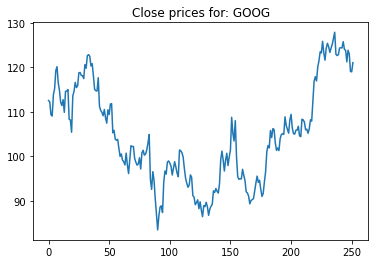

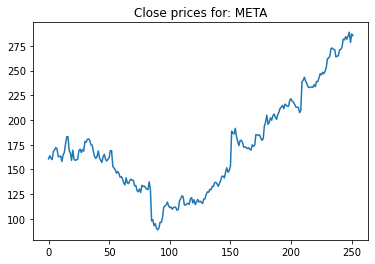

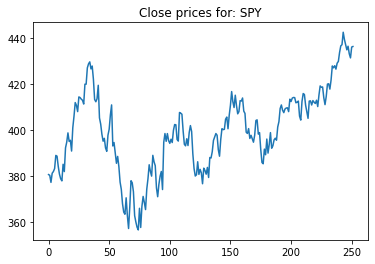

In [5]:
for i in portfolio_df.columns:
    plt.plot(portfolio_df[i])
    plt.title(f"Close prices for: {i}")
    plt.show()

In [6]:
log_returns = []
for i in portfolio_df.columns:
    stock_log_returns = np.log(portfolio_df[i]/portfolio_df[i].shift(1)).dropna().to_list()
    log_returns.append(stock_log_returns)

log_returns = np.array(log_returns).T
log_returns = pd.DataFrame(log_returns, columns=[i for i in portfolio_df.columns])
log_returns.mean() * 252


/Users/yashsolanki/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


GOOG    0.073153
META    0.576379
SPY     0.137201
dtype: float64

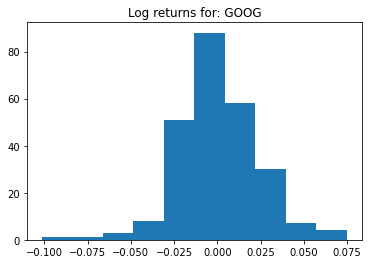

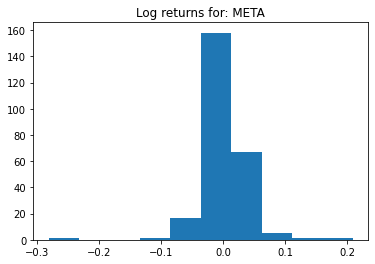

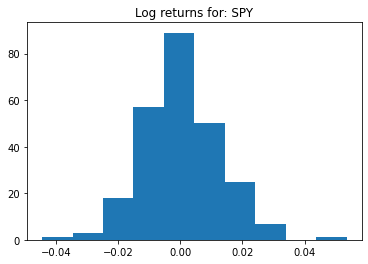

In [7]:
for i in log_returns.columns:
    plt.hist(log_returns[i])
    plt.title(f"Log returns for: {i}")
    plt.show()

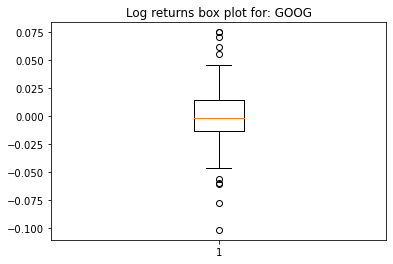

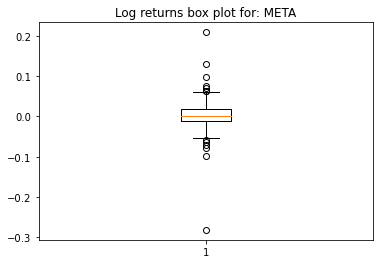

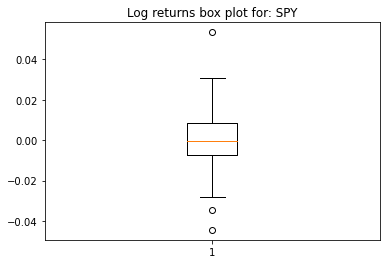

In [8]:
for i in log_returns.columns:
    plt.boxplot(log_returns[i])
    plt.title(f"Log returns box plot for: {i}")
    plt.show()

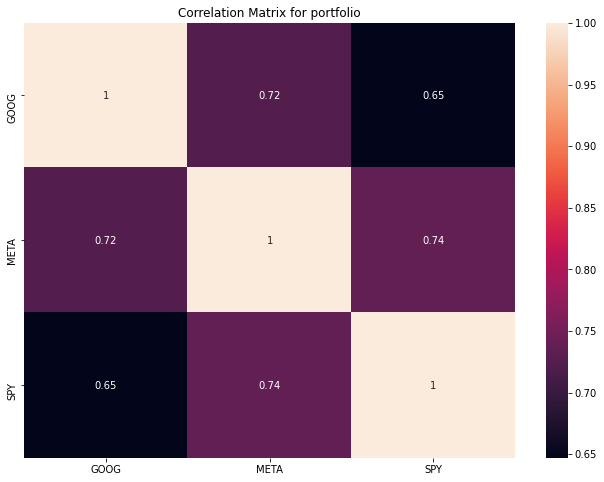

In [9]:
correlation_matrix = portfolio_df.corr()
fig = plt.figure(figsize=[11, 8])
ax = sns.heatmap(correlation_matrix, annot=True)
plt.title("Correlation Matrix for portfolio")
plt.show()

## Calculation of volitality over a certain number of trading days 
Here the sqrt of the number of days is used because std is the square root of the variance and variance is generally proportional to time.

In [10]:
TRADING_DAYS = 60
close_prices_df = pd.DataFrame(close_prices, columns=[i for i in stocks])
# volitality = close_prices_df.rolling(TRADING_DAYS).std() * np.sqrt(TRADING_DAYS) (Use this with pct_change if not using logs)
volitality = log_returns.rolling(TRADING_DAYS).std() * np.sqrt(TRADING_DAYS)

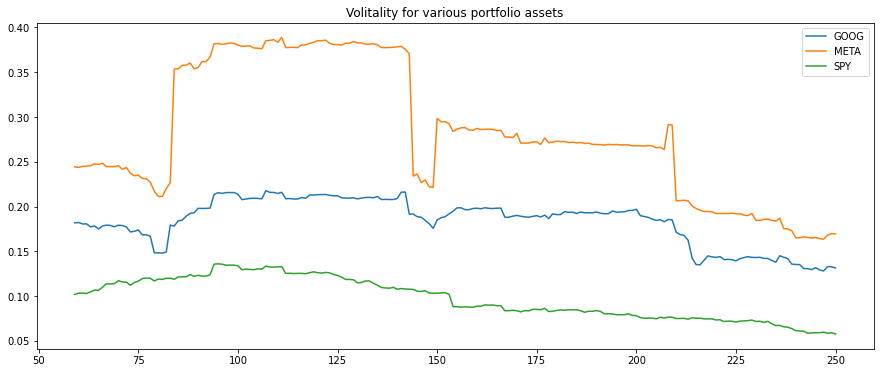

In [11]:
# for i in volitality.columns:
#     fig = plt.figure(figsize=(15, 4))
#     plt.plot(volitality[i])
#     plt.title(f"Volitality of {i} over {TRADING_DAYS} days as per returns")
#     plt.show()

volitality.plot(figsize=(15, 6))
plt.title("Volitality for various portfolio assets")
plt.show()

In [12]:
risk_free_return = 0

In [13]:
sharpe_ratio = (log_returns.rolling(TRADING_DAYS).mean() - risk_free_return) / volitality

# Annualized sharpe ratio = daily sharpe ratio * sqrt(total_days)
annualized_sharpe_ratio = ((log_returns.mean() - risk_free_return) / log_returns.std()) * np.sqrt(TOTAL_DAYS)

In [14]:
print("Annualized Sharpe ratio for the stocks in the portfolio")
for i in range(len(annualized_sharpe_ratio)):
    print(f"{stocks[i]} has a annualized sharpe ratio of: {annualized_sharpe_ratio[i]}")

Annualized Sharpe ratio for the stocks in the portfolio
GOOG has a annualized sharpe ratio of: 0.19807759430791866
META has a annualized sharpe ratio of: 1.0227628806251907
SPY has a annualized sharpe ratio of: 0.7058438825714742


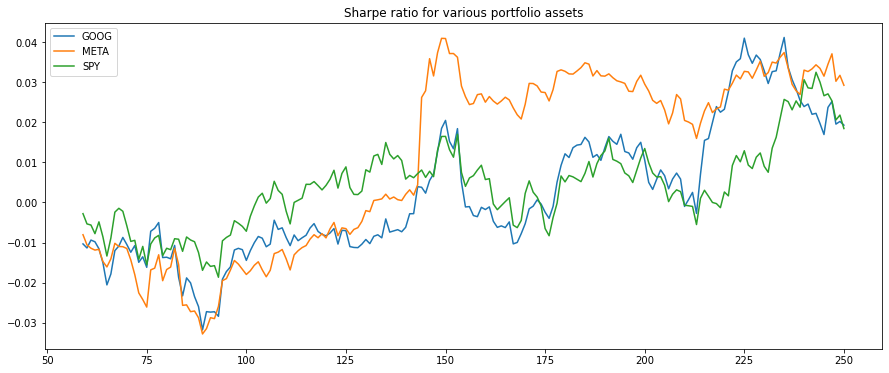

In [15]:
# for i in sharpe_ratio.columns:
#     fig = plt.figure(figsize=(15, 4))
#     plt.plot(sharpe_ratio[i])
#     plt.title(f"Sharpe ratio of {i} over {TRADING_DAYS} days as the len of mean")
#     plt.show()

sharpe_ratio.plot(figsize=(15, 6))
plt.title("Sharpe ratio for various portfolio assets")
plt.show()

## Calculation of the sortino ratio for the individual stocks of the portfolio

In [16]:
downside_volitality = log_returns[log_returns < 0].rolling(TRADING_DAYS, center=True, min_periods=10).std() * np.sqrt(TRADING_DAYS)
sortino_ratio = (log_returns.rolling(TRADING_DAYS).mean() - risk_free_return) / downside_volitality
annualized_sortino_ratio = ((log_returns.mean() - risk_free_return) / downside_volitality.std()) * np.sqrt(TOTAL_DAYS)

In [17]:
print("Annualized Sortino ratio for the stocks in the portfolio")
for i in range(len(annualized_sortino_ratio)):
    print(f"{stocks[i]} has a annualized Sortino ratio of: {annualized_sharpe_ratio[i]}")

Annualized Sortino ratio for the stocks in the portfolio
GOOG has a annualized Sortino ratio of: 0.19807759430791866
META has a annualized Sortino ratio of: 1.0227628806251907
SPY has a annualized Sortino ratio of: 0.7058438825714742


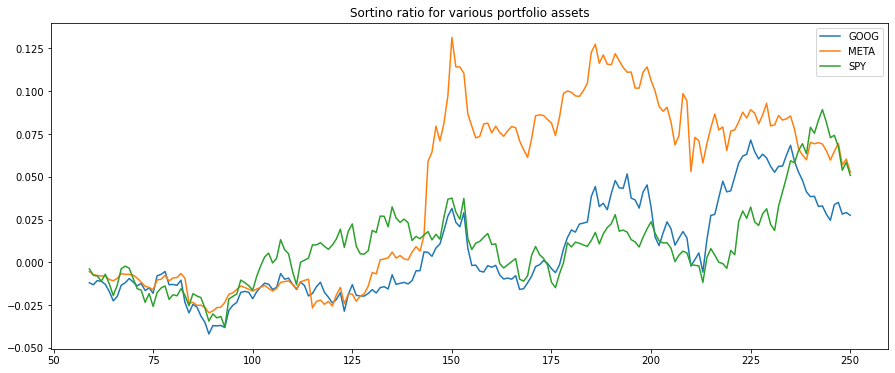

In [18]:
# for i in sortino_ratio.columns:
#     fig = plt.figure(figsize=(15, 4))
#     plt.plot(sortino_ratio[i])
#     plt.title(f"Sortino ratio of {i} over {TRADING_DAYS} days as the len of mean")
#     plt.show()


sortino_ratio.plot(figsize=(15, 6))
plt.title("Sortino ratio for various portfolio assets")
plt.show()

## Calculating the M2 ratio 

In [19]:
BENCHMARK = stocks[0]
benchmark_volitality = volitality[BENCHMARK]
m2_ratios = pd.DataFrame()
for i in log_returns.columns:
    if i != BENCHMARK:
        m2_ratio = sharpe_ratio[i] * benchmark_volitality + risk_free_return
        m2_ratios[i] = m2_ratio


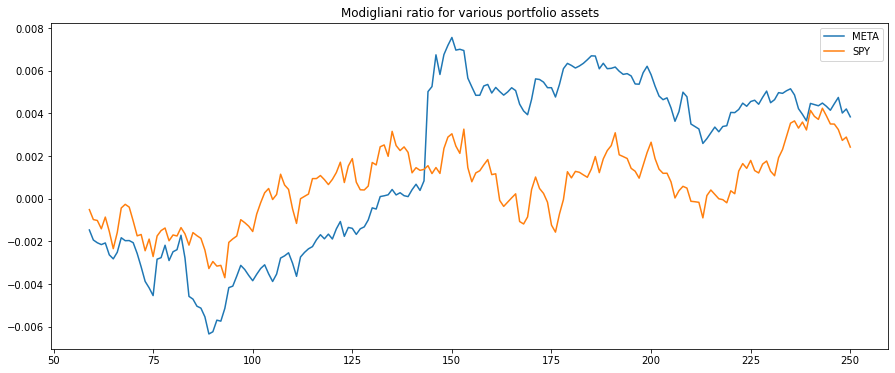

In [20]:
m2_ratios.plot(figsize=(15, 6))
plt.title("Modigliani ratio for various portfolio assets")
plt.show()

## Calculating the Efficient Frontier in order to determine portfolio weightings for diversification

In [21]:
# Equations and inituition from https://www.machinelearningplus.com/machine-learning/portfolio-optimization-python-example/#variance

# This cell is simply a test cell for experiments based of the efficient frontier calculation steps
# num_assets = len(stocks)
# mean_returns = log_returns.mean()
# covariance_matrix = log_returns.cov()
# portfolio_weights = np.array([0, 0.1])
# expected_return = np.dot(mean_returns, portfolio_weights)
# portfolio_std = np.sqrt(np.dot(portfolio_weights.T, np.dot(covariance_matrix, portfolio_weights)))*np.sqrt(252)
# print(f"Portfolio std deviation: {portfolio_std}")

num_assets = len(stocks)
mean_returns = log_returns.mean()
covariance_matrix = log_returns.cov()


In [22]:
portfolio_weights = []
portfolio_returns = []
portfolio_volitality = []

num_portfolios = 1000
returns_n = portfolio_df.pct_change()
covariance_matrix = log_returns.cov() * 252
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    # Ensure that the weights sum up to one
    weights = weights / np.sum(weights)
    portfolio_weights.append(weights)
    # Use portfolio expected return formula
    mean_returns = log_returns.mean() * 252
    returns = np.sum(weights * mean_returns)
    portfolio_returns.append(returns)
    portfolio_volitality.append(np.sqrt(
        np.dot(weights.T, np.dot(log_returns.cov() * 252, weights.T))))

data = {'Returns': portfolio_returns, 'Volatility': portfolio_volitality}
for counter, symbol in enumerate(portfolio_df.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in portfolio_weights]

portfolios = pd.DataFrame(data)
portfolios




,Returns,Volatility,GOOG weight,META weight,SPY weight
0,0.098176,0.315388,0.735496,0.018402,0.246102
1,0.290185,0.342040,0.276168,0.388618,0.335214
2,0.395225,0.429447,0.235328,0.621837,0.142835
3,0.251667,0.281031,0.133738,0.280141,0.586121
4,0.279605,0.350138,0.353677,0.375831,0.270492
...,...,...,...,...,...
995,0.284024,0.376941,0.453534,0.400456,0.146010
996,0.309987,0.362825,0.292139,0.436036,0.271824
997,0.231613,0.287055,0.241624,0.250212,0.508164
998,0.313175,0.366095,0.294149,0.443587,0.262264


In [23]:
min_volitality_portfolio = min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
print(min_volitality_portfolio)
max_sharpe_ratio_portfolio = portfolios.iloc[((portfolios['Returns']-risk_free_return)/portfolios['Volatility']).idxmax()]
print(max_sharpe_ratio_portfolio)


Returns        0.163552
Volatility     0.205216
GOOG weight    0.011519
META weight    0.061682
SPY weight     0.926799
Name: 10, dtype: float64
Returns        0.393566
Volatility     0.381075
GOOG weight    0.001462
META weight    0.583952
SPY weight     0.414586
Name: 980, dtype: float64


In [24]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

portfolios_scatter = go.Scatter(x=portfolios['Volatility'] * 100, y=portfolios['Returns'] * 100, mode='markers', name='Portfolios along efficient frontier')
min_volitality_portfolio_scatter = go.Scatter(
    x=[min_volitality_portfolio[1] * 100], y=[min_volitality_portfolio[0] * 100], marker=dict(color='red', size=14, line=dict(width=3, color='black')), 
    name='Minimum Volitality Portfolio')

max_sharpe_ratio_portfolio_scatter = go.Scatter(
    x=[max_sharpe_ratio_portfolio[1] * 100], y=[max_sharpe_ratio_portfolio[0] * 100], marker=dict(color='green', size=14, line=dict(width=3, color='black')), 
    name='Maximum Sharpe Ratio Portfolio')

data = [portfolios_scatter, min_volitality_portfolio_scatter,
        max_sharpe_ratio_portfolio_scatter]
layout = go.Layout(
    title='Portfolio Optimisation with the Efficient Frontier',
    yaxis=dict(title='Annualised Return (%)'),
    xaxis=dict(title='Annualised Volatility (%)'),
    showlegend=True,
    legend=dict(
        x=0.75, y=0, traceorder='normal',
        bgcolor='#E2E2E2',
        bordercolor='black',
        borderwidth=2),
    width=800,
    height=600)
fig = go.Figure(data=data, layout=layout)
fig.show()


In [25]:
portfolios.head()

,Returns,Volatility,GOOG weight,META weight,SPY weight
0,0.098176,0.315388,0.735496,0.018402,0.246102
1,0.290185,0.342040,0.276168,0.388618,0.335214
2,0.395225,0.429447,0.235328,0.621837,0.142835
3,0.251667,0.281031,0.133738,0.280141,0.586121
4,0.279605,0.350138,0.353677,0.375831,0.270492


[0.001462347133745066, 0.583951901407677, 0.41458575145857796]

## Calculating Beta for the portfolio

In [96]:
benchmark_returns = log_returns['SPY']
weights = [max_sharpe_ratio_portfolio[2:].to_list()]
portfolio_returns = np.dot(weights, log_returns.T)
portfolio_returns = np.reshape(portfolio_returns, (portfolio_returns.shape[1]))
summed_portfolio_returns = np.sum(portfolio_returns) * 100

# Max sharpe ratio portfolio beta
portfolio_beta = pd.DataFrame(np.cov(portfolio_returns, benchmark_returns) / np.var(benchmark_returns))


assets_beta = []
for stock in stocks:
    asset_returns = log_returns[stock]
    asset_beta = np.cov(asset_returns, benchmark_returns) / np.var(benchmark_returns)
    asset_beta = asset_beta[0][1]
    assets_beta.append(asset_beta)

In [97]:
print("Ignore S&P's beta \n\n")

for i in range(len(assets_beta)):
    print(f"Beta of: {stocks[i]} is {assets_beta[i]}")

Ignore S&P's beta 


Beta of: GOOG is 1.4055958299266427
Beta of: META is 1.6538840612507586
Beta of: SPY is 1.004


In [98]:
portfolio_beta = pd.DataFrame(portfolio_beta)
portfolio_beta[0][1]


1.3840883057727413

In [99]:
all_betas = assets_beta
all_betas.append(portfolio_beta[0][1])
all_betas
cols = [i for i in stocks]
cols.append("Portfolio")
betas = pd.DataFrame([all_betas], columns=cols)


In [101]:
betas.T

,0
GOOG,1.405596
META,1.653884
SPY,1.004000
Portfolio,1.384088


## Calculating the expected future returns using the Capital Asset Pricing Model (CAPM)

In [60]:
# Assuming risk-free rate is 0
portfolio_expected_returns = portfolio_beta[1][0] * (max_sharpe_ratio_portfolio[0] * 100)
print(f"Max sharpe ratio portfolio expected returns according to CAPM: {portfolio_expected_returns}%")


assets_expected_returns = []
# print((log_returns['GOOG'].mean() * 252) * 100)
for i in range(len(stocks)):
    asset_expected_return = assets_beta[i] * ((log_returns[stocks[i]].mean() * 252) * 100)
    assets_expected_returns.append(asset_expected_return)


Max sharpe ratio portfolio expected returns according to CAPM: 54.472980304218%


In [61]:
assets_expected_returns


[10.282381956653461, 95.32635283840972, 13.774931935511779]

In [102]:
cumulative_expected_returns = assets_expected_returns
cumulative_expected_returns.append(portfolio_expected_returns)
capm_expected_returns_df = pd.DataFrame([cumulative_expected_returns], columns=cols)

In [104]:
capm_expected_returns_df.T


,0
GOOG,10.282382
META,95.326353
SPY,13.774932
Portfolio,54.472980
